In [380]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv


TIME_WINDOW = 40
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# Backtest the results

train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
test = test.set_index(test.columns[0])
test.index.names = ['']


# Add additional technical indicators
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']


FEATURES = ["close", "high", "low", "volume"].extend(INDICATORS)

In [381]:
test

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
,,,,,,,,,,,,,
0,2021-01-04,133.520004,133.610001,126.760002,126.683434,143301900,AAPL,0,3.389452,56.613023,64.584106,8.436326,37.684726
0,2021-01-04,231.250000,231.250000,223.669998,201.544556,3088200,AMGN,0,-0.377977,48.078728,29.066804,1.082054,37.684726
0,2021-01-04,121.300003,121.800003,116.849998,112.164024,3472100,AXP,0,0.885389,54.746507,-8.190602,3.618340,37.684726
0,2021-01-04,210.000000,210.199997,202.490005,202.720001,21225600,BA,0,1.293101,50.209209,-132.990300,12.708438,37.684726
0,2021-01-04,183.000000,185.979996,180.250000,168.131165,4078300,CAT,0,1.918654,59.272591,142.190862,34.923782,37.684726
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2022-12-30,530.000000,530.500000,524.840027,516.237061,1849600,UNH,4,-0.698874,50.390127,-33.959435,0.949572,5.189315
502,2022-12-30,206.309998,208.039993,205.699997,204.948471,4159400,V,4,-0.172536,52.113767,-56.203566,0.442858,5.189315
502,2022-12-30,39.310001,39.689999,39.070000,34.411125,44007200,VZ,4,0.269587,53.943958,130.079042,28.270982,5.189315


# Portfolio Optimization Algorithm

In [382]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df

df_test = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] < TEST_END_DATE)]


environment = PortfolioOptimizationEnv(
    df_test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\USERS\BENCJ\DESKTOP\ECON4\THESIS\.VENV\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.73325447 0.49973674 0.79356218 0.56069532 0.53807884 0.51365253
 0.47050007 0.4535413  0.4616515  0.57103289 0.46439158 0.53378733
 0.61479425 0.58567169 0.80647558 0.50345004 0.72067673 0.72977091
 0.90836283 0.54361322 0.42626132 0.45990717 0.43075238 0.38731389
 0.36481715 0.39284214 0.37376857 0.32891118 0.30775351 0.41229692
 0.50103437 0.4956013  0.44858818 0.53172473 0.80985935 0.56817462
 0.75831475 0.84203104 0.59513019 0.52325379 0.57803172 0.91159258
 0.78680078 0.78992206 0.66276421 0.57279718 0.52717125 0.45082067
 0.47281647 0.58960399 0.57274243 0.62031431 0.94942914 0.57263856
 0.48849092 0.45299737 0.5057736  0.48134831 0.4135398  0.43837034
 0.60544525 0.38421973 0.45361498 0.41022459 0.42708666 0.45460458
 0.54589994 0.46778252 0.466

In [383]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_24452\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [384]:
EIIE_results = {
    "20212024": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["20212024"]["value"] = environment._asset_memory["final"]
EIIE_results["20212024"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["20212024"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["20212024"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1078330.875
Final accumulative portfolio value: 1.078330875
Maximum DrawDown: -0.21709243061649397
Sharpe ratio: 0.3291363476905392


In [385]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2021-03-02 00:00:00
2022-12-30 00:00:00


# Stock environment optimization algorithm

In [386]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
test = data_split(test, opt_start,opt_end)


In [387]:
print(test)

           date        open        high         low       close     volume  \
0    2021-03-03  124.809998  125.709999  121.839996  119.666840  112966300   
0    2021-03-03  223.520004  225.690002  221.309998  200.606552    2610600   
0    2021-03-03  140.000000  144.250000  140.000000  135.967026    4393700   
0    2021-03-03  226.360001  235.399994  225.039993  228.559998   30426000   
0    2021-03-03  212.139999  217.550003  212.009995  199.425278    2664000   
..          ...         ...         ...         ...         ...        ...   
462  2022-12-30  530.000000  530.500000  524.840027  516.237061    1849600   
462  2022-12-30  206.309998  208.039993  205.699997  204.948471    4159400   
462  2022-12-30   39.310001   39.689999   39.070000   34.411125   44007200   
462  2022-12-30   37.240002   37.380001   36.970001   33.196148    5406200   
462  2022-12-30   47.186668   47.330002   46.936668   46.103809   11505900   

      tic  day      macd     rsi_30      cci_30      dx_30  tur

In [388]:
from stable_baselines3 import PPO, TD3, A2C
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") 

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") 

In [389]:
# Test out of sample performance

stock_dimension = len(test.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [390]:
buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": INITIAL_CASH,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [391]:
e_trade_gym_ppo = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_ppo, df_actions_ppo = StockDRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym_ppo,
    deterministic=True)

hit end!


In [392]:
df_account_value_ppo.rename(columns={'date': 'Date', 'account_value' : "ppo_value"}, inplace=True)
df_account_value_ppo

,Date,ppo_value
0,2021-03-03,1.000000e+06
1,2021-03-04,9.994085e+05
2,2021-03-05,1.001433e+06
3,2021-03-08,1.002683e+06
4,2021-03-09,1.004104e+06
...,...,...
458,2022-12-23,9.435244e+05
459,2022-12-27,9.437858e+05
460,2022-12-28,9.419381e+05
461,2022-12-29,9.440940e+05


In [393]:
e_trade_gym_td3 = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_td3, df_actions_td3 = StockDRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym_td3)

hit end!


In [394]:
df_account_value_td3.rename(columns={'date': 'Date', 'account_value' : "td3_value"}, inplace=True)
df_account_value_td3

,Date,td3_value
0,2021-03-03,1.000000e+06
1,2021-03-04,9.975313e+05
2,2021-03-05,1.005263e+06
3,2021-03-08,1.009639e+06
4,2021-03-09,1.011700e+06
...,...,...
458,2022-12-23,9.510126e+05
459,2022-12-27,9.526733e+05
460,2022-12-28,9.443757e+05
461,2022-12-29,9.550015e+05


In [395]:

e_trade_gym_a2c = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_a2c, df_actions_a2c = StockDRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym_a2c)

df_account_value_a2c.rename(columns={'date': 'Date', 'account_value' : "a2c_value"}, inplace=True)
df_account_value_a2c

hit end!


,Date,a2c_value
0,2021-03-03,1.000000e+06
1,2021-03-04,9.976172e+05
2,2021-03-05,1.001599e+06
3,2021-03-08,1.005979e+06
4,2021-03-09,1.009376e+06
...,...,...
458,2022-12-23,8.829517e+05
459,2022-12-27,8.821270e+05
460,2022-12-28,8.770467e+05
461,2022-12-29,8.851164e+05


In [396]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (463, 8)
Annual return          0.031307
Cumulative returns     0.058273
Annual volatility      0.167496
Sharpe ratio           0.268120
Calmar ratio           0.142689
Stability              0.236982
Max drawdown          -0.219408
Omega ratio            1.046345
Sortino ratio          0.378036
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.001895
Daily value at risk   -0.020924
dtype: float64
df_dji:            date           dji
0   2021-03-02  1.000000e+06
1   2021-03-03  9.961318e+05
2   2021-03-04  9.851113e+05
3   2021-03-05  1.003338e+06
4   2021-03-08  1.013090e+06
..         ...           ...
459 2022-12-23  1.057736e+06
460 2022-12-27  1.058934e+06
461 2022-12-28  1.047280e+06
462 2022-12-29  1.058273e+06
463 2022-12-30           NaN

[464 rows x 2 columns]
df_dji:                       dji
date                    
2021-03-02  1.000000e+06
2021-03-03  9.961318e+05
2021-03-04  9.851113e+05
2021-03-05  1.003338e+06

# Compare all results

In [397]:
# Join the online algorithms

bcrp = pd.read_csv('BCRP_net_worth.csv')
crp = pd.read_csv('CRP_net_worth.csv')
olmar = pd.read_csv('OLMAR_net_worth.csv')



merged_df = pd.merge(bcrp, crp, on='Date')
merged_df = pd.merge(merged_df, olmar, on='Date')


merged_df['Date'] = pd.to_datetime(merged_df['Date'])
df_opt['Date'] = pd.to_datetime(df_opt['Date'])


# Merge the opt algorithm
merged_df = pd.merge(merged_df, df_opt, on='Date')

df_account_value_ppo['Date'] = pd.to_datetime(df_account_value_ppo['Date'])

# Merge the PPO StockEnv data
merged_df = pd.merge(merged_df, df_account_value_ppo, on='Date')


df_account_value_td3['Date'] = pd.to_datetime(df_account_value_td3['Date'])

# Merge the TD3 StockEnv data
merged_df = pd.merge(merged_df, df_account_value_td3, on='Date')

df_account_value_a2c['Date'] = pd.to_datetime(df_account_value_a2c['Date'])

# Merge the A2C StockEnv data
merged_df = pd.merge(merged_df, df_account_value_a2c, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2021-03-02  1.000000e+06
2021-03-03  9.961318e+05
2021-03-04  9.851113e+05
2021-03-05  1.003338e+06
2021-03-08  1.013090e+06
...                  ...
2022-12-23  1.057736e+06
2022-12-27  1.058934e+06
2022-12-28  1.047280e+06
2022-12-29  1.058273e+06
2022-12-30           NaN

[464 rows x 1 columns]
          Date  BCRP_net_worth  CRP_net_worth  OLMAR_net_worth  opt_net_worth  \
0   2021-03-03    9.947251e+05   9.957030e+05     9.958637e+05   9.967019e+05   
1   2021-03-04    9.846573e+05   9.846334e+05     9.847946e+05   9.855839e+05   
2   2021-03-05    1.006264e+06   1.003910e+06     1.004114e+06   1.004934e+06   
3   2021-03-08    1.014408e+06   1.013725e+06     1.014030e+06   1.014788e+06   
4   2021-03-09    1.018603e+06   1.015391e+06     1.015263e+06   1.016463e+06   
..         ...             ...            ...              ...            ...   
458 2022-12-23    1.169677e+06   1.077725e+06     9.779947e+05   1.079000e+06   
459

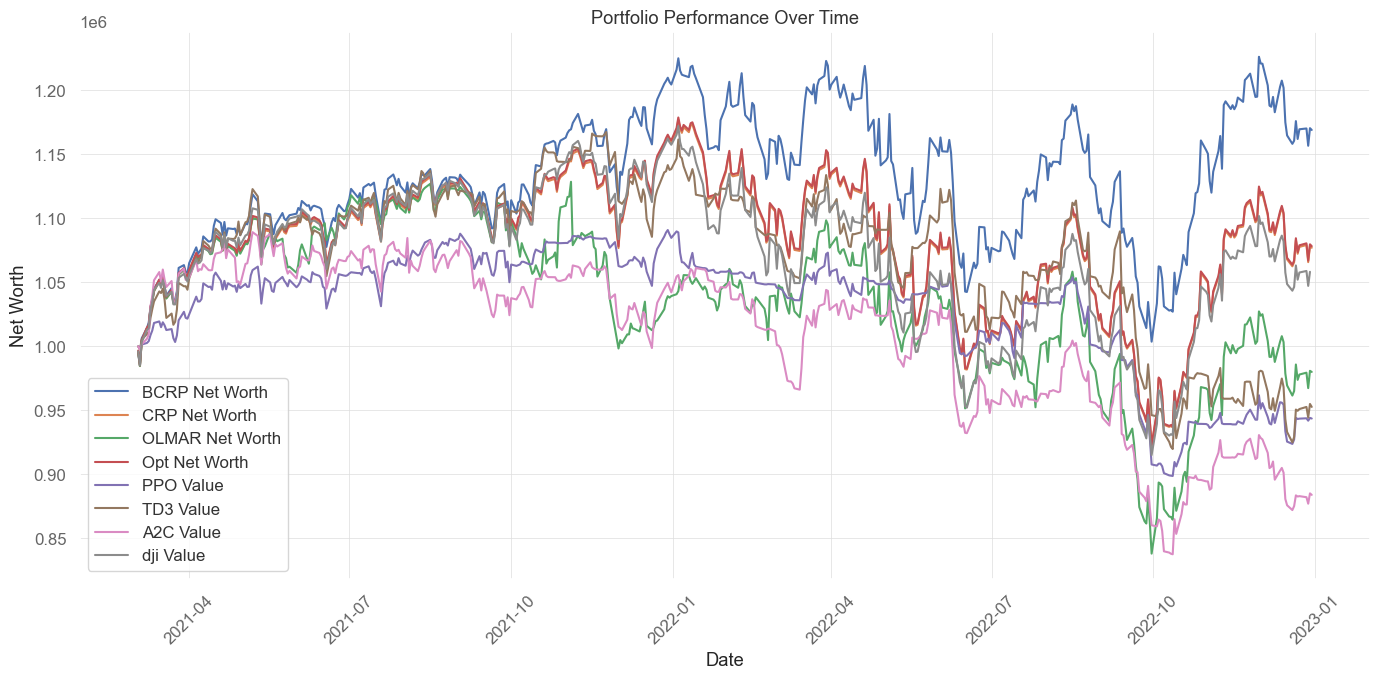

In [398]:
import matplotlib.pyplot as plt

# Plot the DataFrame
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['BCRP_net_worth'], label='BCRP Net Worth')
plt.plot(merged_df['Date'], merged_df['CRP_net_worth'], label='CRP Net Worth')# CRP and Opt net worth are basically on the same line
plt.plot(merged_df['Date'], merged_df['OLMAR_net_worth'], label='OLMAR Net Worth')
plt.plot(merged_df['Date'], merged_df['opt_net_worth'], label='Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_value'], label='PPO Value')
plt.plot(merged_df['Date'], merged_df['td3_value'], label='TD3 Value')
plt.plot(merged_df['Date'], merged_df['a2c_value'], label='A2C Value')
plt.plot(merged_df['Date'], merged_df['dji'], label='dji Value')
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [399]:
import numpy as np

# Calculate the returns each day

merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_daily_return'] = merged_df['ppo_value'].pct_change()
merged_df['td3_daily_return'] = merged_df['td3_value'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

print(sharpe_ratios)

{'BCRP': 0.47756211839222296, 'CRP': 0.22039837672451829, 'OLMAR': -0.07420327607441249, 'Opt': 0.2207977520656131, 'PPO': -0.4599539788718914, 'TD3': -0.22464376454024382}


In [400]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'OLMAR': max_drawdown(merged_df['OLMAR_net_worth']),
    'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_value']),
    'TD3': max_drawdown(merged_df['td3_value'])
}

print(max_drawdowns)


{'BCRP': -0.18076308652736583, 'CRP': -0.21648738634530096, 'OLMAR': -0.2574833118808848, 'Opt': -0.21709243061649397, 'PPO': -0.17619356415743348, 'TD3': -0.2122147249246129}


In [401]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['CRP_daily_return', 'td3_value', 'opt_net_worth', 'ppo_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
print(anova_result)

# The results do seem to be statisitcally significant


                 sum_sq      df              F  PR(>F)
Portfolio  5.378845e+14     3.0  119276.229028     0.0
Residual   2.774889e+12  1846.0            NaN     NaN
